In [1]:
# Set root folder
import sys
import os

cwd = os.getcwd()
folder = os.path.basename(cwd)
cwd = os.path.dirname(cwd)
folder = os.path.basename(cwd)
ROOT = os.path.join(cwd)

sys.path.append(ROOT)

import numpy as np
from core.population import Archive
from environments.environments import *
from parameters import params
import pickle as pkl
import analysis.utils as utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from scipy.stats.mstats import gmean
from core.auto_encoders import *
import torch


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
font = {'size'   : 18}

plt.rc('font', **font)
%matplotlib inline

Root directory /home/giuseppe/src/cmans


In [2]:
env_type = 'arm'

if env_type == 'RW':
    env = 'Walker2D'
elif env_type == 'Dummy':
    env = 'Dummy'
elif env_type == 'CB':
    env = 'CollectBall'
elif env_type == 'AM':
    env = 'AntMaze'
elif env_type == 'arm':
    env = 'NDofArm'
elif env_type == 'maze':
    env = 'HardMaze'
elif env_type == 'cur':
    env = 'Curling'

else:
    raise ValueError('Wrong environment type given: {}'.format(env_type))
    
exp_path = os.path.join(ROOT, 'experiment_data')
# exp_path = EXP_ROOT
exp_types = [
#     'STAX_rew_arch', 
    'STAX-P_multi'#, 'STAX_multi_reset',
#     'TAXONS-P_std', 
#     'TAXONS_std', 
#     'STAX_r_ar_ae',
#     'STAX-NT_multi',
#     'TAXONS_std'
            ]
paths = []

save_path = os.path.join(exp_path, "{}".format(env))

avail_exps = []
for exp_type in exp_types:
    path = os.path.join(exp_path, "{}/{}_{}".format(env, env, exp_type))
#     path = os.path.join(exp_path, "{}_{}".format(env, exp_type))

    if os.path.exists(path):
        paths.append(path)
        avail_exps.append(exp_type)    
        
exp_types = avail_exps
print("Available experiments: {}".format(exp_types))

with open(os.path.join(ROOT, 'analysis/data/{}_img.pkl'.format(env)), 'rb') as f:
    images = pkl.load(f)

Available experiments: ['STAX-P_multi']


# Find best run

In [3]:
def load_data(path):
    data_path = os.path.join(path)
    if os.path.exists(data_path):
        try:
            with open(data_path, 'rb') as file:
                rd = pkl.load(file)
        except Exception as e:
            print('Error on {}'.format(data_path))
            raise
    else:
        print("{} does not exists.".format(data_path))
    return rd

In [4]:
cvgs = {}

for exp, path in zip(exp_types, paths):
    
    runs = utils.get_runs_list(path)
    runs_cvg = []
    
    for run in runs:
        if os.path.exists(os.path.join(path, run, 'analyzed_data/cvg_unif_by_eval.pkl')):
            data = load_data(os.path.join(path, run, 'analyzed_data/cvg_unif_by_eval.pkl'))
            runs_cvg.append(data['cvg'])
            
    cvgs[exp] = np.array(runs_cvg);
    
params.load(os.path.join(path, run, '_params.json'));

grid_parameters = registered_envs[env]['grid']
best_run = {}
for exp, path in zip(exp_types, paths):
    if exp in cvgs:
        try:
            best_run[exp] = np.argmax(np.max(cvgs[exp], axis=1))
        except ValueError:
            best_run[exp] = 0

Loading parameters...
Done


In [5]:
# gens = {'STAX_std': 'final', 'STAX_vae': 'final'}

In [6]:
ae_paths = {}
for exp, path in zip(exp_types, paths):
    runs = utils.get_runs_list(path)
    
    best_run[exp] = os.path.join(path, runs[best_run[exp]])    
    ae_paths[exp] = os.path.join(best_run[exp], 'ae/ae_final.pth' )

# Load AE

In [7]:
aes = []
for exp in ae_paths:
    try:
        ae = ConvAE(bias=True, encoding_shape=10);
        ae.load(ae_paths[exp]);
        print('Loading ConvAE for {}'.format(exp))
    except:
        try:
            ae = ConvAE(bias=False, encoding_shape=8);
            ae.load(ae_paths[exp]);
            print('Loading ConvAE for {}'.format(exp))
        except Exception as e:
            print(exp)
    print("Loaded from: {}".format(ae_paths[exp]))
    print()
    print()
    aes.append(ae)

Loading ConvAE for STAX-P_multi
Loaded from: /home/giuseppe/src/cmans/experiment_data/NDofArm/NDofArm_STAX-P_multi/2021_05_22_19:07_415920/ae/ae_final.pth




# Process data

/home/giuseppe/src/cmans/.venv/lib/python3.7/site-packages/torch/nn/functional.py:2648: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  ret = torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


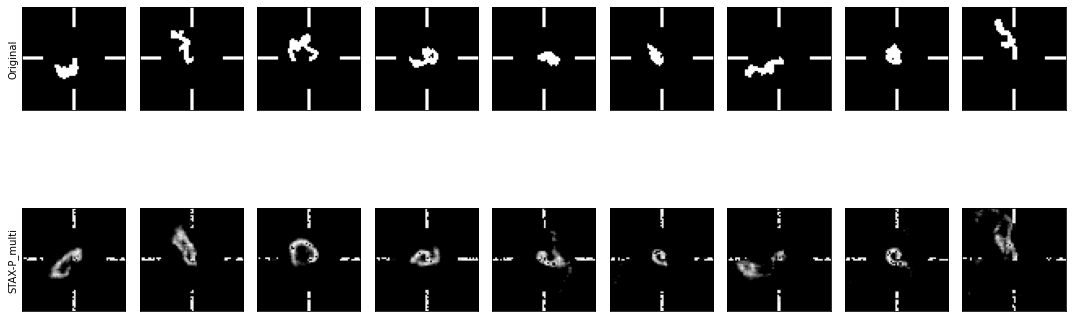

In [8]:
fig, axes = plt.subplots(len(best_run) + 1, len(images), figsize=(15, 7))
fig.patch.set_facecolor('white')
rec_errors = {idx: 0 for idx in range(len(aes))}

# from skimage.color import rgb2gray
# images = np.expand_dims(rgb2gray(images), -1)

for idx, image in enumerate(images):
    axes[0][idx].imshow(image)
    axes[0][idx].set_xticks(ticks=[])
    axes[0][idx].set_yticks(ticks=[])
    im = torch.Tensor([image]).permute((0, 3, 1, 2))
    
    for ae_idx, ae in enumerate(aes):
        with torch.no_grad():
            data = ae(im)
            rec_errors[ae_idx] += data['error'].cpu().numpy()
            y = data['reconstructed'].permute((0, 2, 3, 1)).cpu().numpy()[0]
            axes[ae_idx+1][idx].imshow((y * 255).astype(np.uint8));
            axes[ae_idx+1][idx].set_xticks(ticks=[])
            axes[ae_idx+1][idx].set_yticks(ticks=[])
            

axes[0][0].set_ylabel('Original')
for idx, name in enumerate(best_run):
    axes[idx+1][0].set_ylabel(name)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'ae_reconstruction.pdf'), format='pdf')
plt.show();

In [9]:
print('Reconstruction Errors:')
for idx, exp in enumerate(exp_types):
    print("{}: {}".format(exp, rec_errors[idx]/len(images)))

Reconstruction Errors:
STAX-P_multi: [0.01734389]


# Distance Metrics

In [10]:
rew_archives = {}
archives = {}

for run in best_run:
    params.load(os.path.join(best_run[run], '_params.json'))
    archives[run] = Archive(params)
    archives[run].load(os.path.join(best_run[run], 'archive_final.pkl'))
    
    rew_archives[run] = Archive(params)
    rew_archives[run].load(os.path.join(best_run[run], 'rew_archive_final.pkl'))

Loading parameters...
Done
Loading archive from /home/giuseppe/src/cmans/experiment_data/NDofArm/NDofArm_STAX-P_multi/2021_05_22_19:07_415920/archive_final.pkl
Loading archive from /home/giuseppe/src/cmans/experiment_data/NDofArm/NDofArm_STAX-P_multi/2021_05_22_19:07_415920/rew_archive_final.pkl


#### Find points

In [11]:
# Find reference points in GT BD
points_per_dim = [3,2]
grid = registered_envs[env]['grid']
dims = len(grid['min_coord'])

# Points_per_dim + 2 cause I don't wanna evaluate the extrema
pp = []
for d in range(dims):
    pp.append(np.linspace(grid['min_coord'][d], grid['max_coord'][d], points_per_dim[d]+2)[1:-1])
points = np.reshape(np.meshgrid(*pp), (dims, points_per_dim[0]*points_per_dim[1])).T

In [12]:
# Find agents closest to reference points in GT BD
agents = {}
for run in best_run:
    gt_bd = np.array(archives[run]['gt_bd'] + rew_archives[run]['gt_bd'])
    
    agents[run] = []
    for point in points:
        idx = np.argmin(np.linalg.norm(point-gt_bd, axis=1))
        if idx < archives[run].size:
            agents[run].append(archives[run][idx])
        else:
            agents[run].append(rew_archives[run][idx-archives[run].size])

In [13]:
# Calculate distances
gt_dist = {}
bd_dist = {}

for run in best_run:
    gt_bd = np.array(archives[run]['gt_bd'] + rew_archives[run]['gt_bd'])
    bd = np.array(archives[run]['bd'] + rew_archives[run]['bd'])
    
    gt_dist[run] = []
    bd_dist[run] = []
    for agent in agents[run]:
        bd_dist[run].append(np.linalg.norm(agent[1]-bd, axis=1)) # bd
        gt_dist[run].append(np.linalg.norm(agent[10]-gt_bd, axis=1))

Corr coeff: 0.409359695025828
Corr coeff: 0.5097300929049532
Corr coeff: 0.7329023376522426
Corr coeff: 0.5484137940640834
Corr coeff: 0.3545174517865271
Corr coeff: 0.4085415903527412


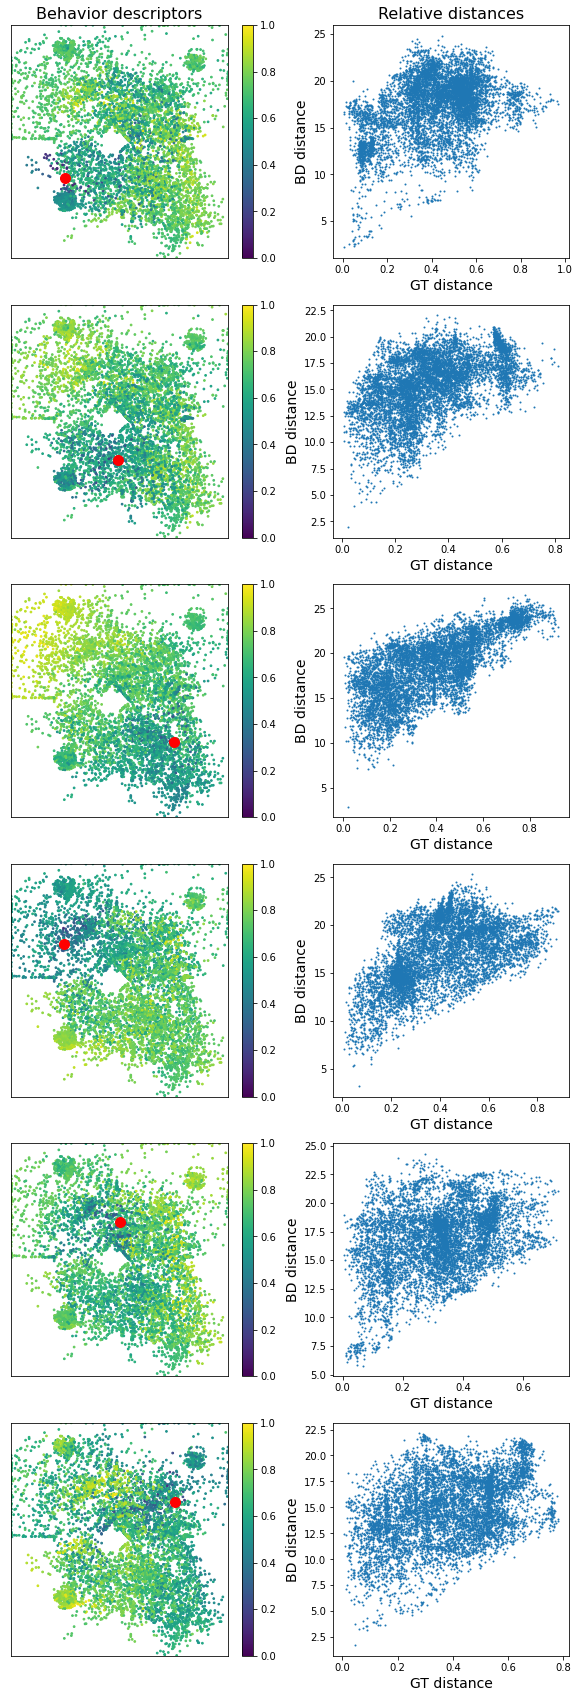

In [54]:
fig, ax = plt.subplots(points_per_dim[0]*points_per_dim[1], 2, figsize=(10,30), gridspec_kw={'width_ratios': [1.5, 1.3]})
fig.patch.set_facecolor('white')


    
scaling = max([np.max(bd_dist[run]) for run in best_run])
for idx, run in enumerate(best_run):
    gt_bd = np.array(archives[run]['gt_bd'] + rew_archives[run]['gt_bd'])
    
    for p_idx, agent in enumerate(agents[run]):
        z = bd_dist[run][p_idx]
        z_max = max(z)
        x = gt_bd[:, 0].ravel()
        y = gt_bd[:, 1].ravel()
        z = z/z_max
        z = z.ravel()
        c = ax[p_idx][0].scatter(x[::-1], y[::-1], c=z[::-1], s=3)
        ax[p_idx][0].scatter(agent[10][0], agent[10][1], c='r', s=100)        
        ax[p_idx][0].axis([0, 1, 0, 1])
        fig.colorbar(c, ax=ax[p_idx][0])
        ax[p_idx][0].set_xticks(ticks=[])
        ax[p_idx][0].set_yticks(ticks=[])
        
# for idx, name in enumerate(best_run):
#     ax[idx][0].set_title(name)

for array, bds, aa in zip(gt_dist['STAX-P_multi'], bd_dist['STAX-P_multi'], ax):
    idx = np.argsort(array)
    data = np.array([np.array([array[i], bds[i]]) for i in idx])
    aa[1].scatter(data[1:, 0], data[1:, 1], s=1)
    aa[1].set_xlabel('GT distance', fontsize=14)
    aa[1].set_ylabel('BD distance', fontsize=14)
    print("Corr coeff: {}".format(np.corrcoef(data[1:, 0], data[1:, 1])[0, 1]))

ax[0][0].set_title('Behavior descriptors',fontsize=16)
ax[0][1].set_title('Relative distances', fontsize=16)

#plt.tight_layout()
with open(os.path.join(save_path, 'ae_bd_points.png'), 'wb') as f:
    plt.savefig(f, format='png');
plt.show();